# Curiosity Mastcam - Reconstruction Detections

> Caution: important experiment, please do not adjust
> The contents within this file are for running a publication-quality experiment and producing the associated figures and results. As such, it is finely tuned for specific high-quality graphics using the `primary.mplstyle` file. Please do not adjust. If you need to replicate results on your local system, please create a new notebook and copy contents from here.

## Imports and Configuration

In [5]:
import sys
sys.path.append('../..')  # Expose top level program access

import time
import pickle
import logging
import torch
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from functools import reduce
from pathlib import Path

from modules.cae_base_module import CAEBaseModule
from modules.vae_base_module import VAEBaseModule
from modules.aae_base_module import AAEBaseModule
from modules.pca_base_module import PCABaseModule
from models import supported_models
from datasets import supported_datamodules
from utils import tools, metrics, supported_preprocessing_transforms
from utils.dtypes import *

logging.getLogger("matplotlib").setLevel(logging.WARNING)  # Suppress verbose font warnings from matplotlib

Search for configurations and trained models in the *logs* directory for the datamodule under experiment: *CuriosityDataModule*. 

In [6]:
# Import configurations and paths to logged models
root = Path.cwd().parents[1]
log_path = root / 'logs' / 'CuriosityDataModule'
paths_to_archived_models = list(Path(log_path).glob('**/archive_v*'))

print('Found archived models:\n------')
print('\n'.join([f'{p.parent.name}/{p.name}' for p in paths_to_archived_models]))

Found archived models:
------



In [16]:
def load_modules(paths_to_archived_models: List[Path]) -> dict:
    # Load the checkpoints for all the training modules and save them in a dictionary
    module_catalog = {}

    for pth in paths_to_archived_models:

        model_type = pth.parent.name
        model_name = pth.name
        config = tools.load_config(pth / 'configuration.yaml', silent=True)
        print(f'Loading state dict for: {model_type}/{model_name}')

        # Unsupervising region proposal is called implicity in this line, see utils/preprocessing.py
        preprocessing_transforms = supported_preprocessing_transforms[config['data-parameters']['preprocessing']]

        datamodule = supported_datamodules[config['experiment-parameters']['datamodule']](
            data_transforms=preprocessing_transforms,
            **config['data-parameters'])

        if 'PCA' in model_type:

            _, pca_test_labels = datamodule.split(train=False)

            with open(pth / 'fitted_model.p', 'rb') as f:
                model = pickle.load(f)
                module = PCABaseModule(model)
        else:
            ckpt_path = next(iter((pth / 'checkpoints').glob('val_*')))

            datamodule.setup('test')

            # Handle the various model instantiations
            if 'AAE' in model_type:
                model = supported_models[model_type](
                    in_shape=datamodule.data_shape,
                    latent_nodes=config['module-parameters']['latent_nodes'])
                module = AAEBaseModule(model, **config['module-parameters'])
            elif 'VAE' in model_type:
                model = supported_models[model_type](
                    in_shape=datamodule.data_shape,
                    latent_nodes=config['module-parameters']['latent_nodes'])
                module = VAEBaseModule(model, **config['module-parameters'])
            elif 'CAE' in model_type:
                model = supported_models[model_type](in_shape=datamodule.data_shape)
                module = CAEBaseModule(model, **config['module-parameters'])
            else:
                raise ValueError(f'Model substring not found, got {model_type}')

            # Load the state_dict into the module architecture
            checkpoint = torch.load(ckpt_path)
            module.load_state_dict(checkpoint['state_dict'])

        if model_type not in module_catalog:
            module_catalog[model_type] = {}
        module_catalog[model_type][model_name] = module
        
    if 'pca_test_labels' in locals():
        return module_catalog, datamodule, pca_test_labels
    return module_catalog, datamodule, -1
        
module_catalog, datamodule, pca_test_labels = load_modules(paths_to_archived_models)

NameError: name 'List' is not defined

## Evaluation

In [4]:
# Collect scores and labels on test set for all models and save to a dictionary
result_catalog = {}

for model_type, model_variants in module_catalog.items():
    start_time = time.time()
    
    for model_name, module in model_variants.items():
        
        test_novelty_scores = []
        test_novelty_labels = []
        short_name = model_type + '-' + model_name.split('_')[1]
        if short_name not in result_catalog:
            result_catalog[short_name] = {
                'scores': [], 
                'labels': []
            }
        print(f'------\n{short_name}\n------')
        
        # Handle the PCA and autoencoder frameworks separately
        if 'PCA' in short_name:
            test_novelty_scores = module.transform_pipeline(datamodule)
            test_novelty_labels = pca_test_labels
        else:
        
            # Set the model/components in evaluation mode
            if 'AAE' in model_type:
                module.encoder.eval()
                module.decoder.eval()
            else:
                module.model.eval()
        
            with torch.no_grad():
                for batch_nb, batch in enumerate(datamodule.test_dataloader()):

                    result = module.test_step(batch, batch_nb)

                    test_novelty_scores.extend(result['scores'])
                    test_novelty_labels.extend(result['labels'].cpu().numpy())
                    print(f'[BATCH {batch_nb}] Mean score: {np.mean(result["scores"])}')
                    
        result_catalog[short_name]['scores'] = test_novelty_scores
        result_catalog[short_name]['labels'] = test_novelty_labels
        print(f'{short_name} Time: {time.time() - start_time:.2f} s\n')

------
SimpleVAE-v2
------
[BATCH 0] Mean score: 0.6704217791557312
[BATCH 1] Mean score: 0.696747362613678
[BATCH 2] Mean score: 0.8310810327529907
[BATCH 3] Mean score: 0.8000250458717346
SimpleVAE-v2 Time: 5.37 s

------
SimpleVAE-v1
------
[BATCH 0] Mean score: 0.642200231552124
[BATCH 1] Mean score: 0.6740671396255493
[BATCH 2] Mean score: 0.8156729936599731
[BATCH 3] Mean score: 0.7849459052085876
SimpleVAE-v1 Time: 8.27 s

------
BaselineVAE-v2
------
[BATCH 0] Mean score: 0.6607077121734619
[BATCH 1] Mean score: 0.6862615346908569
[BATCH 2] Mean score: 0.8129045367240906
[BATCH 3] Mean score: 0.7835743427276611
BaselineVAE-v2 Time: 16.13 s

------
BaselineVAE-v1
------
[BATCH 0] Mean score: 0.6418886184692383
[BATCH 1] Mean score: 0.6707273721694946
[BATCH 2] Mean score: 0.8097025156021118
[BATCH 3] Mean score: 0.7811291217803955
BaselineVAE-v1 Time: 31.59 s

------
BaselineCAE-v3
------
[BATCH 0] Mean score: 0.3061293661594391
[BATCH 1] Mean score: 0.30835679173469543
[BATCH 2

## Analysis

### ROC

SimpleVAE-v2: 633.1541748046875
SimpleVAE-v1: 614.8521118164062
BaselineVAE-v2: 621.8821411132812
BaselineVAE-v1: 612.0531616210938
BaselineCAE-v3: 271.19091796875
BaselineCAE-v2: 277.3619384765625
BaselineCAE-v4: 334.9726257324219
BaselineCAE-v1: 329.97918701171875
CompressionCAEHighCapacity-v1: 415.75299072265625
StandardPCA-v1: 27.84030764873214
CompressionCAEMidCapacity-v1: 431.72015380859375
BaselineAAE-v2: 586.4090576171875
BaselineAAE-v1: 466.80859375


2021-05-19 11:39:49,667 - WARNING - findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
2021-05-19 11:39:49,673 - WARNING - findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
2021-05-19 11:39:52,201 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 11:39:52,202 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 11:39:52,203 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 11:39:52,203 - DEBUG - STREAM b'pHYs' 128 9
2021-05-19 11:39:52,204 - DEBUG - STREAM b'IDAT' 149 96
2021-05-19 11:39:52,206 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 11:39:52,206 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 11:39:52,207 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 11:39:52,208 - DEBUG - STREAM b'pHYs' 128 9
2021-05-19 11:39:52,208 - DEBUG - STREAM b'IDAT' 149 129
2021-05-19 11:39:52,210 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 11:39:52,210 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 11:39:52,211 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 11:39:52,211 - DEBUG - STREAM b'pHYs' 128 9
2021-05-

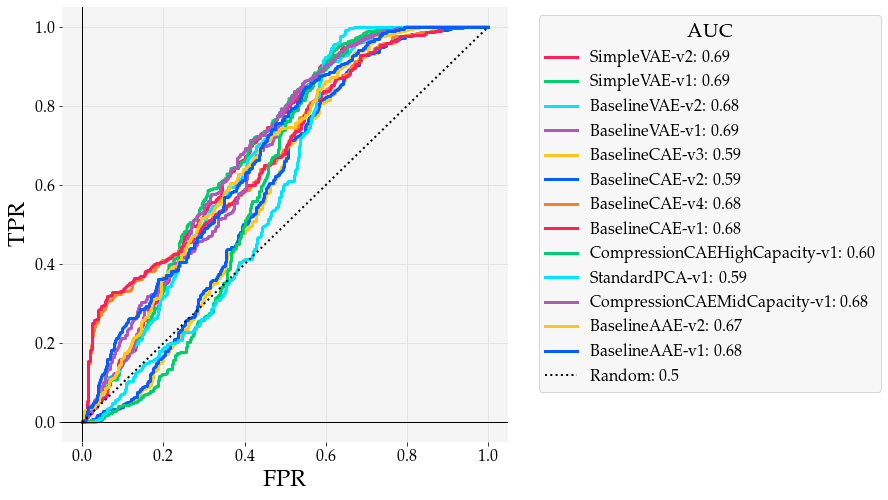

Random ROC AUC: 0.5


In [5]:
# Use standard custom styling
plt.style.use('../../utils/_extras/primary.mplstyle')

# Plot the ROC curves with AUCs for each model
fig, ax = plt.subplots(figsize=(8, 8))
for sn, results in result_catalog.items():

    scores = results['scores']
    labels = results['labels']
    print(f'{sn}: {sum(scores)}')
    
    fpr, tpr, thresholds, auc = metrics.roc(scores, labels)
    
    ax.plot(fpr, tpr, label=f'{sn}: {auc:.2f}')
    
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.plot([0., 1.], [0., 1.], 'k:', lw=2, label='Random: 0.5')
ax.legend(title='AUC', bbox_to_anchor=(1.05, 1.), loc='upper left')

ax.axhline(0, 0, c='k', lw=1)
ax.axvline(0, 0, c='k', lw=1)

plt.savefig('ROC-all_CuriosityMastcam.pdf', format='pdf', bbox_inches='tight')
plt.show()
print('Random ROC AUC: 0.5')

### Precision at k

2021-05-19 11:43:33,294 - DEBUG - STREAM b'IHDR' 16 13
2021-05-19 11:43:33,295 - DEBUG - STREAM b'PLTE' 41 48
2021-05-19 11:43:33,295 - DEBUG - STREAM b'tRNS' 101 15
2021-05-19 11:43:33,296 - DEBUG - STREAM b'pHYs' 128 9
2021-05-19 11:43:33,296 - DEBUG - STREAM b'IDAT' 149 478


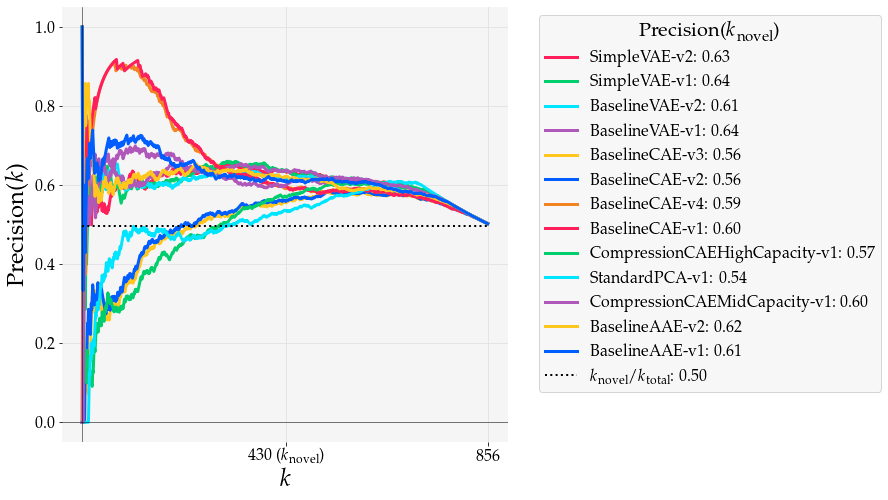

In [13]:
# Plot the Precision(k) across all test images.
fig, ax = plt.subplots(figsize=(8, 8))
for sn, results in result_catalog.items():
    
    scores = results['scores']
    labels = results['labels']
    pak = metrics.precision_at_k(scores, labels)

    uniques, counts = np.unique(labels, return_counts=True)
    random = counts.min() / counts.sum()

    ax.plot(pak, label=f'{sn}: {pak[int(sum(labels))]:.2f}')
    
ax.plot([0, len(pak)], [random, random], 'k:', lw=2, 
        label='$k_{\mathrm{novel}}/k_{\mathrm{total}}$: '+f'{counts[1]/counts.sum():.2f}')

ax.set_xlabel('$k$')
ax.set_ylabel('Precision($k$)')
ax.legend(title='Precision($k_{\mathrm{novel}}$)', bbox_to_anchor=(1.05, 1.), loc='upper left')

ax.set_xticks([counts[1], counts.sum()])
ax.set_xticklabels([str(counts[1])+' ($k_{\mathrm{novel}}$)', counts.sum()])

# Draw axes for styling
ax.axhline(0, 0, c='k', lw=0.5)
ax.axvline(0, 0, c='k', lw=0.5)

plt.savefig('Pak-all_CuriosityMastcam.pdf', format='pdf', bbox_inches='tight')
plt.show()